Install the necessary libraries

In [23]:
!pip install numpy
import numpy as np

In [51]:
!pip install findspark

In [3]:
!pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


Initializing Apache Spark  


In [11]:
import findspark
findspark.init("/Users/connor/spark/spark-3.5.4-bin-hadoop3");

In [2]:
# warnings are annoying
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from datasets import load_dataset
from itertools import islice

import matplotlib.pyplot as plt
from wordcloud import WordCloud

Retrieve and display basic system information

In [26]:
import socket
import platform
import psutil


ip_address = socket.gethostbyname(socket.gethostname())
pc_name = socket.gethostname()


system_info = platform.uname()
ram = round(psutil.virtual_memory().total / (1024 ** 3), 2)
cpu_count = psutil.cpu_count(logical=True)

print(f"IP Address: {ip_address}")
print(f"PC Name: {pc_name}")
print(f"System: {system_info.system}, Version: {system_info.version}")
print(f"Processor: {system_info.processor}")
print(f"Total RAM: {ram} GB")
print(f"CPU Core Count: {cpu_count}")

IP Address: 127.0.0.1
PC Name: Znar-MacBook-Air.local
System: Darwin, Version: Darwin Kernel Version 24.2.0: Fri Dec  6 18:40:14 PST 2024; root:xnu-11215.61.5~2/RELEASE_ARM64_T8103
Processor: arm
Total RAM: 8.0 GB
CPU Core Count: 8


Initialize Spark and configure session settings for optimized performance.

In [4]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("OptimizedALS") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.cores", "2") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()
sc = spark.sparkContext

25/01/31 13:09:22 WARN Utils: Your hostname, Znar-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.49 instead (on interface en0)
25/01/31 13:09:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/31 13:09:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
print(f'App Name : {sc.appName}')
print(f'Version : {sc.version}')
print(f"Spark User : {sc.sparkUser()}")

App Name : OptimizedALS
Version : 3.5.4
Spark User : connor


In [6]:
dataset = load_dataset("ashraq/movielens_ratings")  

25/01/31 13:09:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
df = dataset['train'].to_pandas()
df.head()

,imdbId,tmdbId,movie_id,user_id,rating,title,genres,posters
0,tt2096673,150540,2307,11923,3.5,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,https://m.media-amazon.com/images/M/MV5BOTgxMD...
1,tt5160928,393732,7157,32503,3.0,Mean Dreams (2017),Thriller,https://m.media-amazon.com/images/M/MV5BMDM2OD...
2,tt3498820,271110,1398,20241,3.0,Captain America: Civil War (2016),Action|Sci-Fi|Thriller,https://m.media-amazon.com/images/M/MV5BMjQ0MT...
3,tt3040964,278927,2625,42975,5.0,The Jungle Book (2016),Adventure|Drama|Fantasy,https://m.media-amazon.com/images/M/MV5BMTc3NT...
4,tt5308322,440021,8457,31336,3.0,Happy Death Day (2017),Horror|Mystery|Thriller,https://m.media-amazon.com/images/M/MV5BYzZhY2...


In [8]:
df_train = dataset['train'].to_pandas()[['movie_id', 'user_id', 'rating', 'genres', 'title']]
df_val = dataset['validation'].to_pandas()[['movie_id', 'user_id', 'rating', 'genres', 'title']]

In [25]:
print(df_train.count())
print(df_val.count())

movie_id    891382
user_id     891382
rating      891382
genres      891382
title       891382
dtype: int64
movie_id    99043
user_id     99043
rating      99043
genres      99043
title       99043
dtype: int64


In [18]:
df_train.to_csv("./df_train.csv", index=False)
df_val.to_csv('./df_val.csv', index=False)

In [19]:
df_rating_train = spark.read.csv("./df_train.csv", header=True, inferSchema=True).select('movie_id', 'user_id', 'rating')
df_rating_val = spark.read.csv("./df_val.csv", header=True, inferSchema=True).select('movie_id', 'user_id', 'rating')
concat_data = df_rating_train.union(df_rating_val)
genres_train = spark.read.csv("./df_train.csv", header=True, inferSchema=True).select('genres') 
genres_val = spark.read.csv("./df_val.csv", header=True, inferSchema=True).select('genres')
concat_genres = genres_train.union(genres_val)
title_train = spark.read.csv("./df_train.csv", header=True, inferSchema=True).select(['movie_id', 'title']) 
title_val = spark.read.csv("./df_val.csv", header=True, inferSchema=True).select(['movie_id', 'title'])
movie_title = title_train.union(title_val)
ratings_df =concat_data.limit(1000000)





In [20]:
ratings_df.show()

+--------+-------+------+
|movie_id|user_id|rating|
+--------+-------+------+
|    2307|  11923|   3.5|
|    7157|  32503|   3.0|
|    1398|  20241|   3.0|
|    2625|  42975|   5.0|
|    8457|  31336|   3.0|
|    2230|  38922|   4.0|
|    5110|  41802|   3.5|
|     935|  36706|   3.5|
|     936|  21320|   5.0|
|    8960|   2930|   2.5|
|    5054|   3084|   0.5|
|    5946|  32002|   2.5|
|     361|  25766|   0.5|
|    2651|  25308|   4.0|
|    5946|  35938|   4.0|
|   12530|   2631|   2.0|
|    2458|   6638|   4.0|
|   11532|  31139|   2.5|
|    5440|  33031|   3.0|
|     667|  12551|   3.0|
+--------+-------+------+
only showing top 20 rows



In [21]:
ratings_df.describe().show()

+-------+------------------+------------------+------------------+
|summary|          movie_id|           user_id|            rating|
+-------+------------------+------------------+------------------+
|  count|            990425|            990425|            990425|
|   mean| 4057.249363657016|21788.655097559127|3.5557376883661056|
| stddev|3782.8968929842445|12658.790818877977| 1.052182268814748|
|    min|                 1|                 1|               0.5|
|    max|             15604|             44088|               5.0|
+-------+------------------+------------------+------------------+



In [22]:
print(f"Number of rows : {ratings_df.count()}")

Number of rows : 990425


Count the number of null values in each column of the ratings DataFrame.

In [36]:
from pyspark.sql.functions import count, when, col
ratings_df.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings_df.columns]).show()

+--------+-------+------+
|movie_id|user_id|rating|
+--------+-------+------+
|       0|      0|     0|
+--------+-------+------+



In [40]:
concat_genres.show(5)

+--------------------+
|              genres|
+--------------------+
|Adventure|Animati...|
|            Thriller|
|Action|Sci-Fi|Thr...|
|Adventure|Drama|F...|
|Horror|Mystery|Th...|
+--------------------+
only showing top 5 rows



Convert a list of genres into a single text string and parallelize it as an RDD.

In [14]:
genres_list = []

for genres in concat_genres.collect():
    genres_list.append(genres[0])

genres_text = ""

for g in genres_list:
    genres_text += g + "|"
rdd = sc.parallelize([genres_text])


In [15]:
all_genres = rdd.flatMap(lambda genres: genres.split('|')) \
    .map(lambda genres : (genres, 1)) \
    .reduceByKey(lambda x, y, : x + y)

sortedGenresCounts = sorted(all_genres.collect(), key=lambda x : x[1], reverse=True)
sortedGenresCounts = spark.sparkContext.parallelize(sortedGenresCounts)
for genres, count in islice(sortedGenresCounts.collect(), 15):
    print(f"{genres}: {count}")

25/01/30 23:06:54 WARN TaskSetManager: Stage 17 contains a task of very large size (17884 KiB). The maximum recommended task size is 1000 KiB.


Drama: 405151
Action: 294340
Comedy: 275970
Adventure: 233625
Thriller: 223726
Sci-Fi: 208094
Fantasy: 113806
Crime: 111199
Animation: 106115
Romance: 87352
Horror: 80338
Children: 63295
Mystery: 48418
Documentary: 41649
War: 39009


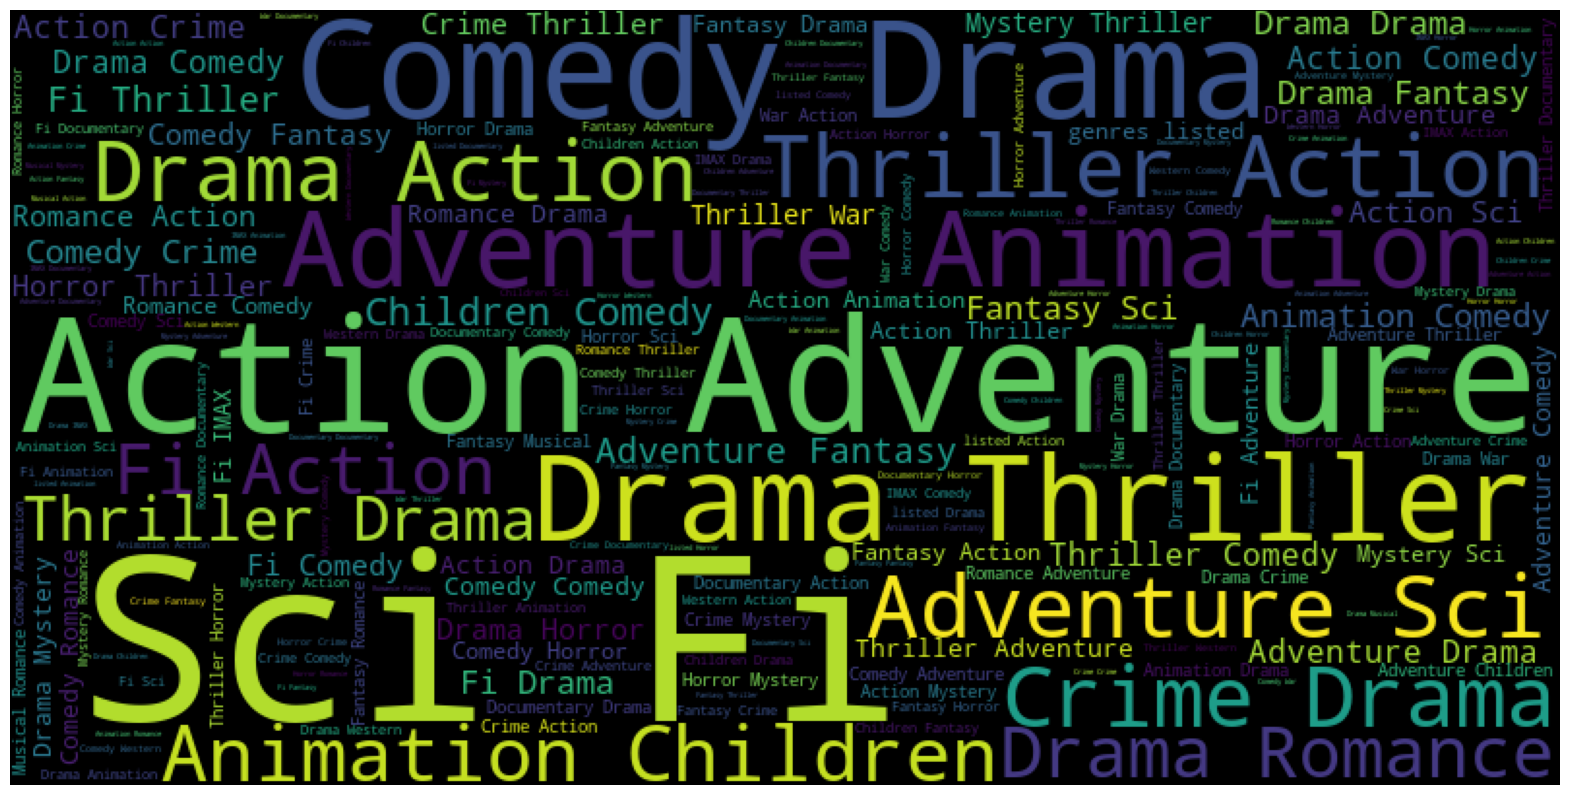

In [48]:
# Plot the top 15 genres in a wordcloud chart
plt.subplots(figsize=(20, 15))
genres_cloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(genres_list))
plt.imshow(genres_cloud)
plt.axis('off')
plt.show()

<Axes: ylabel='count'>

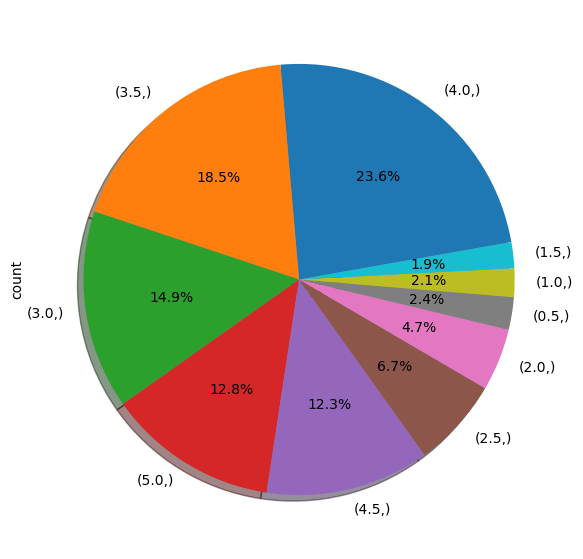

In [49]:
# Plot ratings distribution in a pie chart
plt.figure(figsize=(7, 7))
rating_list = [rating[0] for rating in concat_data.select("rating").collect()]
pd.DataFrame(rating_list).value_counts().plot(
    kind='pie',
    shadow=True,
    startangle=10,
    autopct='%1.1f%%',
    )

Text(0, 0.5, 'Frequency')

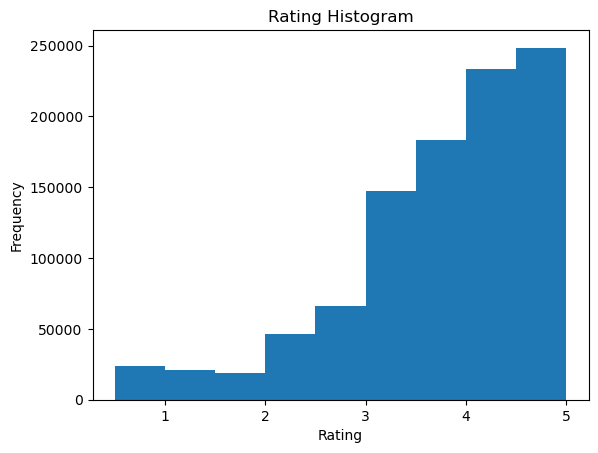

In [54]:
# Plot ratings distribution in a histogram
bin_edges = np.arange(0.5, 5.5, step=0.5)

plt.hist(
    rating_list, bins=bin_edges, histtype='bar'
)

plt.title("Rating Histogram")
plt.xlabel('Rating')    
plt.ylabel('Frequency')

In [16]:
(training_df, test_df) = ratings_df.randomSplit([0.7, 0.3], seed=5039)
print(training_df.count())
test_df.count()

693094


297331

Initialize a list for models and create a DataFrame to store model evaluation metrics.

In [17]:
models = []

df = pd.DataFrame(columns=['rank_', 'iteration', 'regParam_', 'model', 'predictions', 'rmse', 'mse'])

Create the model architecture using the ALS algorithm.

In [18]:
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

def als_model(rank_, iteration, regParam_):
        # Creating the Alternating Least Squares (ALS) model
        als = ALS(
                rank = rank_,  # Number of factors (latent factors)
                maxIter = iteration,  # Maximum number of iterations
                regParam = regParam_,  # Regularization parameter
                
                numUserBlocks = 10,
                numItemBlocks = 10,  # Number of item (movie) blocks
                implicitPrefs = False,  # Using explicit ratings
                alpha = 1.0,  # Used in implicit mode (we are in explicit mode)
                userCol = 'user_id',
                itemCol = 'movie_id',
                seed = 5039,
                ratingCol = 'rating',
                nonnegative = False,  # Non-negative factors (False: negative values are allowed)
                checkpointInterval = 10,  # Checkpoint frequency
                intermediateStorageLevel = 'MEMORY_AND_DISK',
                finalStorageLevel = 'MEMORY_AND_DISK',
                coldStartStrategy = 'nan',
                blockSize = 4096,
        )

        model = als.fit(training_df)

        model.setPredictionCol("predictions")

        predictions = model.transform(test_df)

        # Filtering out NaN (invalid) predictions
        predictions = predictions.filter(predictions.predictions != float('nan'))

        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="predictions")
        rmse = evaluator.evaluate(predictions) 

        
        evaluator2 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="predictions")
        mse = evaluator2.evaluate(predictions)
        
        models.append(model)    

        df.loc[len(df)] = [rank_, iteration, regParam_, model, predictions, rmse, mse] 


Train the ALS model using different combinations of hyperparameters

In [19]:
from itertools import product
rank_params = [10, 50, 100] 
iteration_params = [10, 15, 20]
lambda_params = [0.1, 0.01]

# Train the model with different hyperparameters
for r, i, l in product(rank_params, iteration_params, lambda_params):
    als_model(r, i, l)
    print(f"model {len(df)} is done ")

25/01/30 23:07:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/01/30 23:07:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/01/30 23:07:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


model 1 is done 


model 2 is done 


model 3 is done 


model 4 is done 


model 5 is done 


model 6 is done 


model 7 is done 


model 8 is done 


model 9 is done 


model 10 is done 


model 11 is done 


model 12 is done 


model 13 is done 


model 14 is done 


model 15 is done 


model 16 is done 


model 17 is done 


model 18 is done 


In [20]:
print(df['mse'].min())
print(df['rmse'].min())


0.7166207125356199
0.8465345312127674


Get the model with the minimum MSE and RMSE

In [21]:

model_mse = [m for m in models if m == df.groupby('mse').min().iloc[0]['model']][0] 

model_rmse = [m for m in models if m == df.groupby('rmse').min().iloc[0]['model']][0]

if model_rmse == model_mse:
    model = model_rmse
    print("models are same")
else:
    print("models arenot same")

models are same


In [22]:
df[df['model'] == model].drop(columns=['model'])  

,rank_,iteration,regParam_,predictions,rmse,mse
4,10,20,0.1,"DataFrame[movie_id: int, user_id: int, rating:...",0.846535,0.716621


Get the predictions of the model

In [23]:
predictions = df[df['model'] == model]['predictions'].values[0]
predictions.take(10)

[Row(movie_id=5, user_id=27484, rating=4.0, predictions=4.054470062255859),
 Row(movie_id=5, user_id=43302, rating=3.5, predictions=4.160249710083008),
 Row(movie_id=7, user_id=17389, rating=4.0, predictions=3.464498281478882),
 Row(movie_id=13, user_id=28200, rating=4.5, predictions=3.0162429809570312),
 Row(movie_id=17, user_id=5202, rating=3.5, predictions=3.049057722091675),
 Row(movie_id=17, user_id=31983, rating=4.5, predictions=3.7138307094573975),
 Row(movie_id=18, user_id=28383, rating=4.0, predictions=2.9389286041259766),
 Row(movie_id=19, user_id=12753, rating=4.0, predictions=3.5427300930023193),
 Row(movie_id=19, user_id=16481, rating=3.0, predictions=3.463146209716797),
 Row(movie_id=19, user_id=27484, rating=3.0, predictions=3.849604606628418)]

In [24]:
predictions = predictions.select(['rating', 'predictions'])

prediction_df = predictions.toPandas()

sorted_df = prediction_df.sort_values(by='rating')
sorted_df = sorted_df.sort_values(by='predictions')

Plot error distribution in a histogram

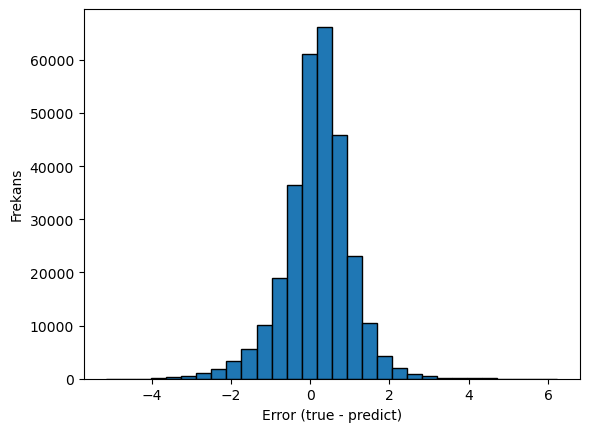

In [25]:
errors = [real - predicted for real, predicted in zip(sorted_df['rating'].values, sorted_df['predictions'].values)]

plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Error (true - predict)')
plt.ylabel('Frekans')
plt.show()

Find the top N users who are most similar to the given product based on user and item factors using cosine similarity.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
def find_similar_users(Model, product_id, n_users=10):
    item_factors = Model.itemFactors.filter(col("id") == product_id).collect()[0].features
    
    user_factors = Model.userFactors.collect()
    
    similarities = []
    for user in user_factors:
        sim = cosine_similarity(
            item_factors.reshape(1, -1),
            user.features.reshape(1, -1)
        )[0][0]
        similarities.append((user.id, sim))
    
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:n_users]

Find the top N users most similar to the given product using cosine similarity between product and user factors, and display their similarity scores.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_users(Model, product_id, n_users=10):
    item_factors = Model.itemFactors.filter(col("id") == product_id).collect()[0].features
    item_factors = np.array(item_factors)
    
    user_factors = Model.userFactors.collect()
    
    similarities = []
    for user in user_factors:
        user_features = np.array(user.features)
        
        sim = cosine_similarity(
            item_factors.reshape(1, -1),
            user_features.reshape(1, -1)
        )[0][0]
        similarities.append((user.id, sim))
    
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:n_users]

example_movie_id = 296  
similar_users = find_similar_users(model, example_movie_id)

print("\nTop 10 Users Most Likely to Like Movie", example_movie_id)
for user_id, similarity in similar_users:
    print(f"User {user_id}: Similarity Score = {similarity:.4f}")



Top 10 Users Most Likely to Like Movie 296
User 35606: Similarity Score = 0.9853
User 16295: Similarity Score = 0.9789
User 590: Similarity Score = 0.9766
User 31161: Similarity Score = 0.9764
User 17421: Similarity Score = 0.9759
User 40319: Similarity Score = 0.9748
User 23510: Similarity Score = 0.9747
User 30714: Similarity Score = 0.9738
User 39108: Similarity Score = 0.9737
User 23574: Similarity Score = 0.9721
